In [1]:
import STAGATE_pyG
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
from memory_profiler import memory_usage
from scipy.io import mmread
import time
import torch

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
adata=sc.read_h5ad('/home/dbj/SpaLP/Tutorialdata/CosMxMouseBrain.h5ad')
adata.var_names_make_unique()
adata.obs['truth']=adata.obs['spatialClusteringAssignments']
adata.obs['truth'] = adata.obs['truth'].astype('category')
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 48180 × 950
    obs: 'spatialClusteringAssignments', 'truth'
    uns: 'RNA_nbclust_clusters_colors', 'spatialClusteringAssignments_colors', 'log1p'
    obsm: 'spatial'

In [4]:
device_idx=0
def measure_resources(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        mem_usage = memory_usage((func, args, kwargs), max_usage=True) / 1024
        end_time = time.time()
        execution_time = end_time - start_time
        minutes = execution_time // 60
        seconds = execution_time % 60
        if torch.cuda.is_available():
            device = torch.device(f"cuda:{device_idx}")
            allocated = torch.cuda.memory_allocated(device) / (1024 ** 3) 
            cached = torch.cuda.memory_reserved(device) / (1024 ** 3)
        else:
            allocated = cached = 0

        print(f"Function '{func.__name__}' executed in {minutes} minutes and {seconds:.4f} seconds.")
        print(f"Memory usage: {mem_usage:.2f} GB")
        print(f"GPU memory allocated: {allocated:.2f} GB")
        print(f"GPU memory cached: {cached:.2f} GB")

    return wrapper

------Calculating spatial graph...
The graph contains 481800 edges, 48180 cells.
10.0000 neighbors per cell on average.


/home/dbj/STAGATE/STAGATE_pyG/utils.py:194: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/dbj/STAGATE/STAGATE_pyG/utils.py:194: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))


Size of Input:  (48180, 950)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 21.09it/s]


Function 'run_pipeline' executed in 0.0 minutes and 59.6704 seconds.
Memory usage: 1.39 GB
GPU memory allocated: 0.28 GB
GPU memory cached: 7.56 GB


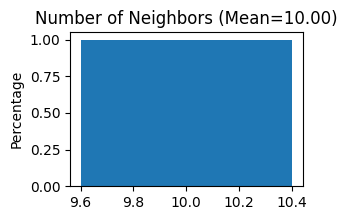

In [5]:
@measure_resources
def run_pipeline(adata):
    STAGATE_pyG.Cal_Spatial_Net(adata, k_cutoff=10,model='KNN')
    STAGATE_pyG.Stats_Spatial_Net(adata)
    adata = STAGATE_pyG.train_STAGATE(adata, device = device)
run_pipeline(adata=adata)


In [6]:
@measure_resources
def run_leiden(adata):
    sc.pp.neighbors(adata, use_rep='STAGATE')
    sc.tl.leiden(adata, random_state=2024, resolution=0.533,key_added='STAGATE_leiden')
run_leiden(adata=adata)

Function 'run_leiden' executed in 0.0 minutes and 54.4474 seconds.
Memory usage: 1.83 GB
GPU memory allocated: 0.02 GB
GPU memory cached: 7.56 GB


/home/dbj/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dbj/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/dbj/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_m

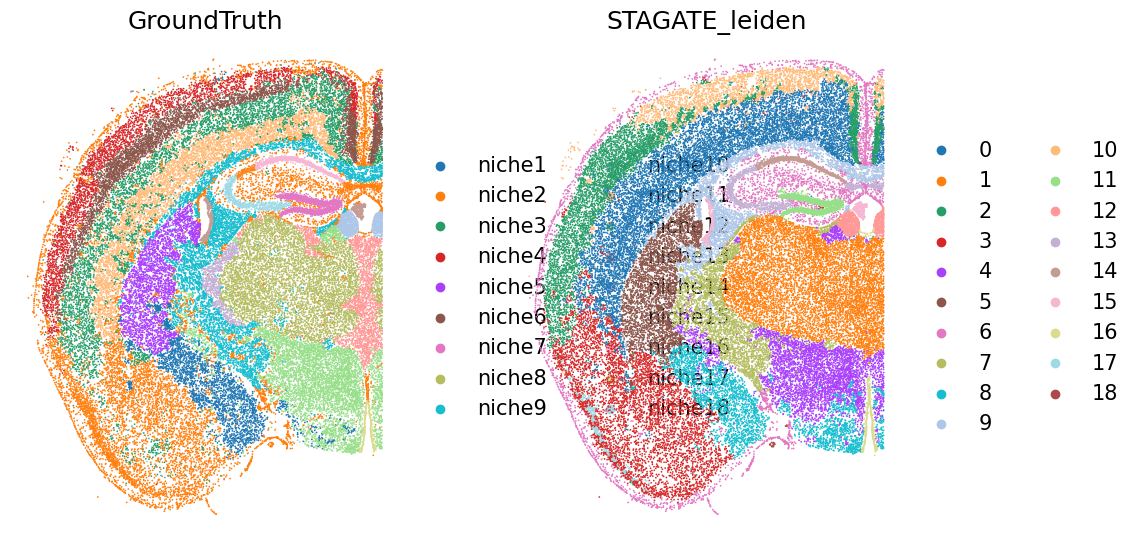

In [7]:
import matplotlib.pyplot as plt
import copy
from scanpy.plotting import palettes
plt.rcParams['figure.figsize'] = (5,6.5)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata, basis="spatial",s=6, color=['spatialClusteringAssignments','STAGATE_leiden'],colorbar_loc=None,title='GroundTruth',frameon=False,palette=palettes.default_20)

In [8]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata.obs['spatialClusteringAssignments'])
cluster_labels = np.array(adata.obs['STAGATE_leiden'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)
print("Homogeneity:", homogeneity)

ARI: 0.49323189304117376
NMI: 0.6974894188264905
AMI: 0.697110347659883
FMI: 0.5398892031235003
V-Measure: 0.6974894188264905
Homogeneity: 0.6992035420552707


In [13]:
from sklearn.cluster import KMeans
@measure_resources
def run_kmeans(adata):
    kmeans = KMeans(n_clusters=19, random_state=2024) 
    labels = kmeans.fit_predict(adata.obsm['STAGATE'])
    adata.obs['STAGATE_kmeans']=labels.astype(str)
run_kmeans(adata=adata)

Function 'run_kmeans' executed in 0.0 minutes and 1.2597 seconds.
Memory usage: 1.72 GB
GPU memory allocated: 0.02 GB
GPU memory cached: 7.56 GB


/home/dbj/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dbj/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/home/dbj/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dbj/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


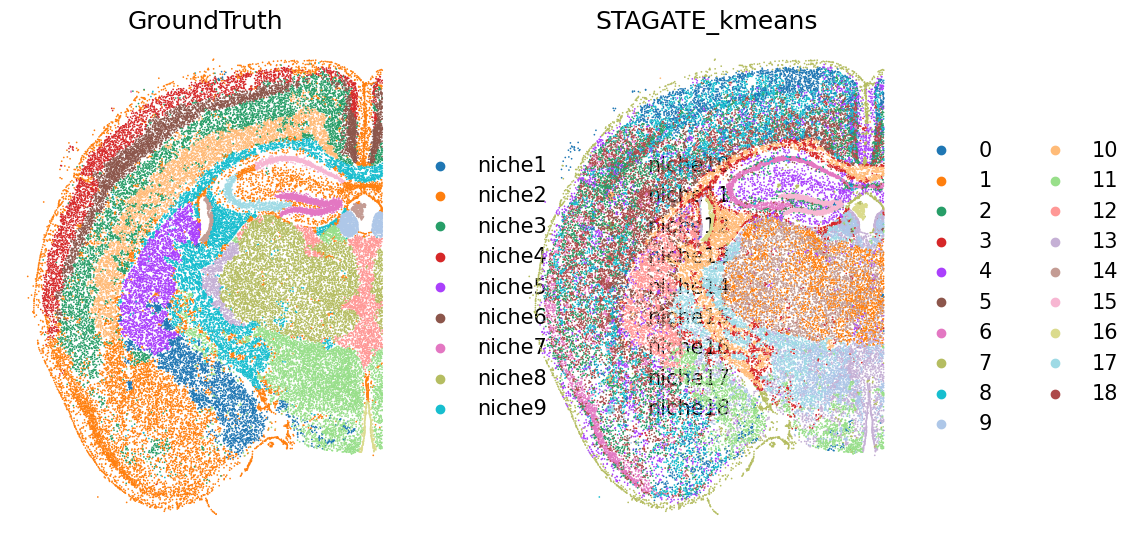

In [14]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (5,6.5)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata, basis="spatial",s=6, color=['spatialClusteringAssignments','STAGATE_kmeans'],colorbar_loc=None,title='GroundTruth',frameon=False,palette=palettes.default_20)

In [15]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata.obs['spatialClusteringAssignments'])
cluster_labels = np.array(adata.obs['STAGATE_kmeans'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)
print("Homogeneity:", homogeneity)

ARI: 0.24493282834065563
NMI: 0.4850066595193065
AMI: 0.48439861694123276
FMI: 0.30735212051063027
V-Measure: 0.48500665951930644
Homogeneity: 0.5134385616454152


In [16]:
adata.write_h5ad('/home/dbj/STAGATE/STAGATE_CosMx_mousebrain_k_10.h5ad',compression='gzip')